In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import warnings

import math
from pathlib import Path

import scipy


from sklearn import model_selection, metrics
from lightgbm import LGBMClassifier, LGBMRegressor
import lightgbm as lgb
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import optuna
import optuna_integration
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


from colorama import Fore
from GPyOpt.methods import BayesianOptimization 
import time

warnings.filterwarnings("ignore")

c:\Users\90530\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path= 'C:/Users/90530/OneDrive/Masaüstü/kaggle_Flood/'

train = pd.read_csv(path + 'flood_train.csv')
sub = pd.read_csv(path + 'sample_submission.csv')
test = pd.read_csv(path + 'flood_test.csv')

In [3]:
print(f' train shape: {train.shape}\n test shape: {test.shape}')

 train shape: (1167957, 30)
 test shape: (745305, 29)


In [7]:
def get_summary(df):
    df_desc = pd.DataFrame(df.describe(include='all').transpose())
    df_summary = pd.DataFrame({
        'dtype': df.dtypes,
        '#missing': df.isnull().sum().values,
        '#duplicates': df.duplicated().sum(),
        '#unique': df.nunique().values,
        'min': df_desc['min'].values,
        'max': df_desc['max'].values,
        'avg': df_desc['mean'].values,
        'std dev': df_desc['std'].values,
    })
    return df_summary

get_summary(train).style.background_gradient()

,dtype,#missing,#duplicates,#unique,min,max,avg,std dev
MonsoonIntensity,int64,0,0,17,0.000000,16.000000,4.924448,2.064482
TopographyDrainage,int64,0,0,19,0.000000,18.000000,4.929129,2.100671
RiverManagement,int64,0,0,17,0.000000,16.000000,4.957917,2.079283
Deforestation,int64,0,0,18,0.000000,17.000000,4.945076,2.059346
Urbanization,int64,0,0,18,0.000000,17.000000,4.944509,2.090501
ClimateChange,int64,0,0,18,0.000000,17.000000,4.936415,2.065289
DamsQuality,int64,0,0,17,0.000000,16.000000,4.958424,2.090286
Siltation,int64,0,0,17,0.000000,16.000000,4.930394,2.073436
AgriculturalPractices,int64,0,0,17,0.000000,16.000000,4.945338,2.075964
Encroachments,int64,0,0,19,0.000000,18.000000,4.951676,2.090378


In [8]:
get_summary(test).style.background_gradient()

,dtype,#missing,#duplicates,#unique,min,max,avg,std dev
MonsoonIntensity,int64,0,0,17,0.000000,16.000000,4.915610,2.056295
TopographyDrainage,int64,0,0,18,0.000000,17.000000,4.930288,2.094117
RiverManagement,int64,0,0,17,0.000000,16.000000,4.960027,2.071722
Deforestation,int64,0,0,18,0.000000,17.000000,4.946084,2.052602
Urbanization,int64,0,0,18,0.000000,17.000000,4.938424,2.081816
ClimateChange,int64,0,0,18,0.000000,17.000000,4.933524,2.059243
DamsQuality,int64,0,0,17,0.000000,16.000000,4.958468,2.089312
Siltation,int64,0,0,17,0.000000,16.000000,4.927651,2.068110
AgriculturalPractices,int64,0,0,17,0.000000,16.000000,4.945308,2.073404
Encroachments,int64,0,0,18,0.000000,17.000000,4.950620,2.081750


* We don't have any missing values
* No duplicates
* all features are continuous
* Target is float
* On first sight, no differences between train, test and original dataset, but we'll check on that below

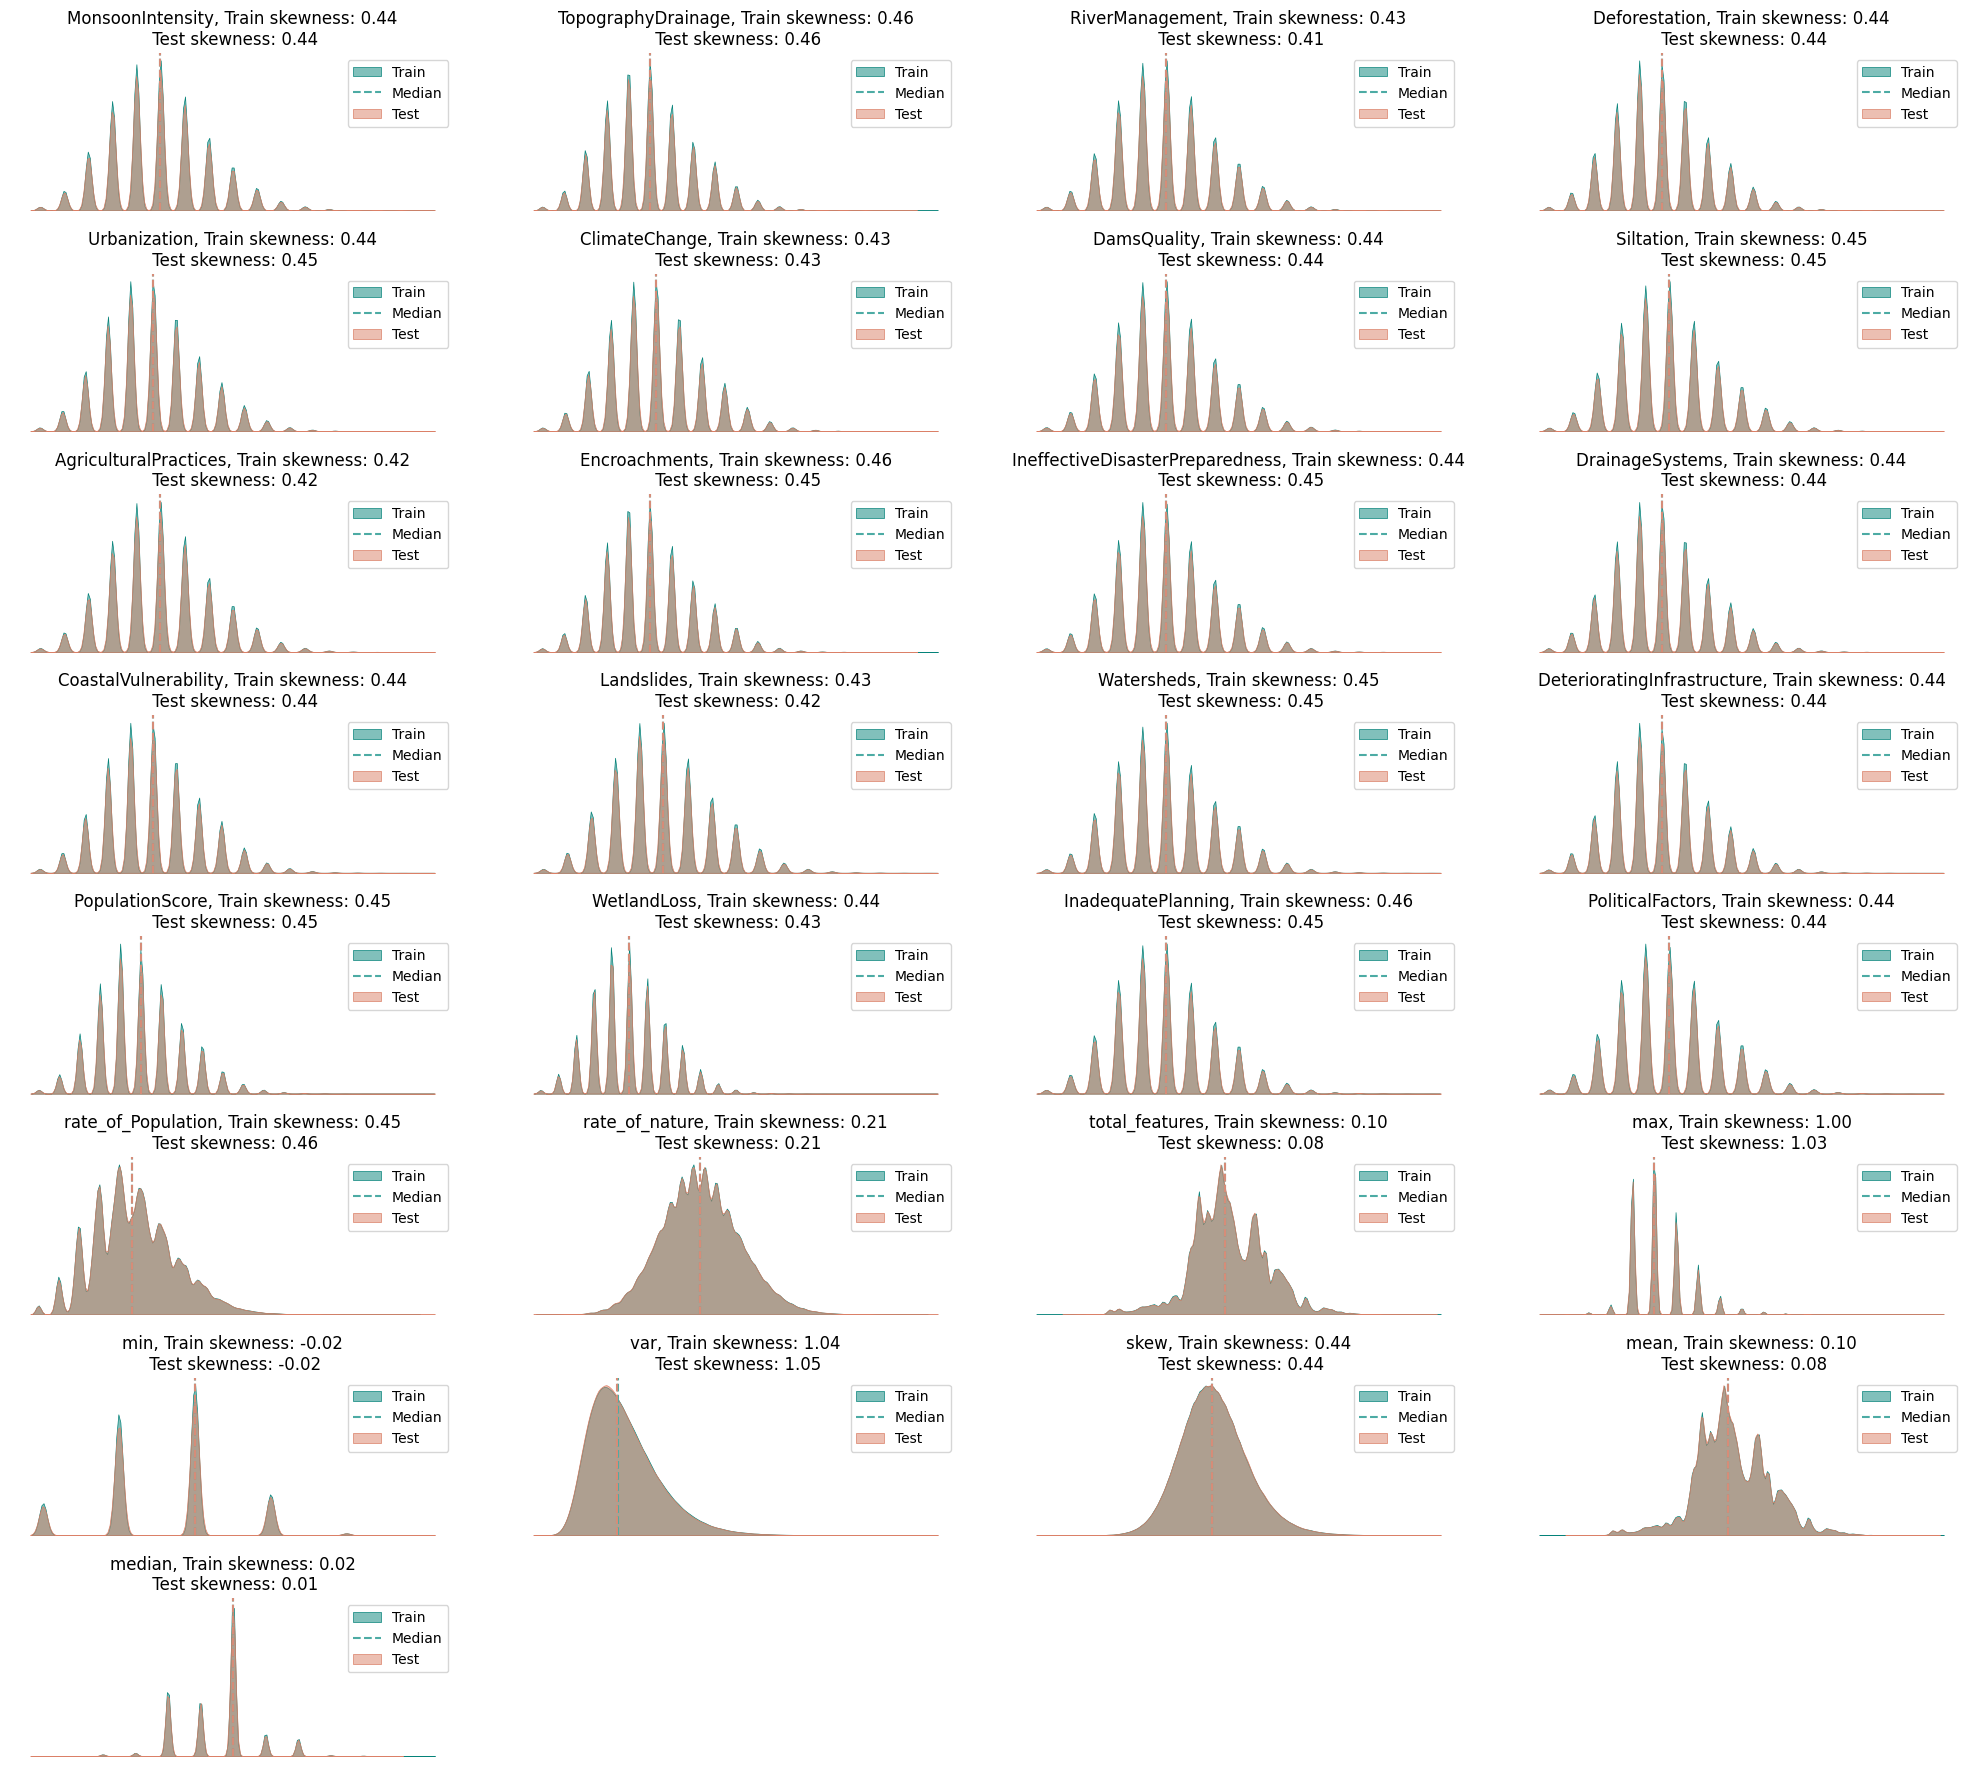

In [16]:
def dist(df_features: pd.DataFrame, 
         df_features_2: None, 
         ncols=4, 
         labels: tuple[str, str] = ('Train', 'Test'),
         hide_xlabel=True,
         hide_ylabel=True,
        ) -> None:
    assert df_features_2 is None or set(df_features.columns) == set(df_features_2.columns) 
    
    nrows = (math.ceil(df_features.shape[1]/ncols))
    fig, axes = plt.subplots(nrows=nrows, 
                            ncols=min(df_features.shape[1], ncols), 
                            figsize=(20, nrows*2 + 2))
    axes = axes.flatten() if df_features.shape[1] > 1 else [axes]
    
    for i, col in enumerate(df_features):
        sns.kdeplot(df_features[col], ax=axes[i], fill=True, alpha=0.5, linewidth=0.5, color='#058279', label='Train')
        median_features = df_features[col].median()
        axes[i].axvline(x=median_features, color='#4caba4', linestyle='--')
        if df_features_2 is not None:
            sns.kdeplot(df_features_2[col], ax=axes[i], fill=True, alpha=0.5, linewidth=0.5, color='#db8067', label='Test')
            title = f'{col}, {labels[0]} skewness: {df_features[col].skew():.2f}\n {labels[1]} skewness: {df_features_2[col].skew():.2f}'
            median_features_2 = df_features_2[col].median()
            axes[i].axvline(x=median_features_2, color='#d68c78', linestyle='--')
            axes[i].legend(labels=[labels[0], 'Median', labels[1]])
        else:
            title = f'{col}, skewness: {df_features[col].skew():.2f}'
            axes[i].legend(labels=[labels[0], 'Median'])
        axes[i].set_title(title)
        if hide_xlabel:
            axes[i].set_xlabel('')
            axes[i].set_xticks([])
        if hide_ylabel:
            axes[i].set_ylabel('')
            axes[i].set_yticks([])
        
    plt.tight_layout()
    sns.despine(left=True, bottom=True)
    [fig.delaxes(ax) for ax in axes if not ax.has_data()]
    
dist(df_features=train[test.columns], 
     df_features_2=test[test.columns]
    )

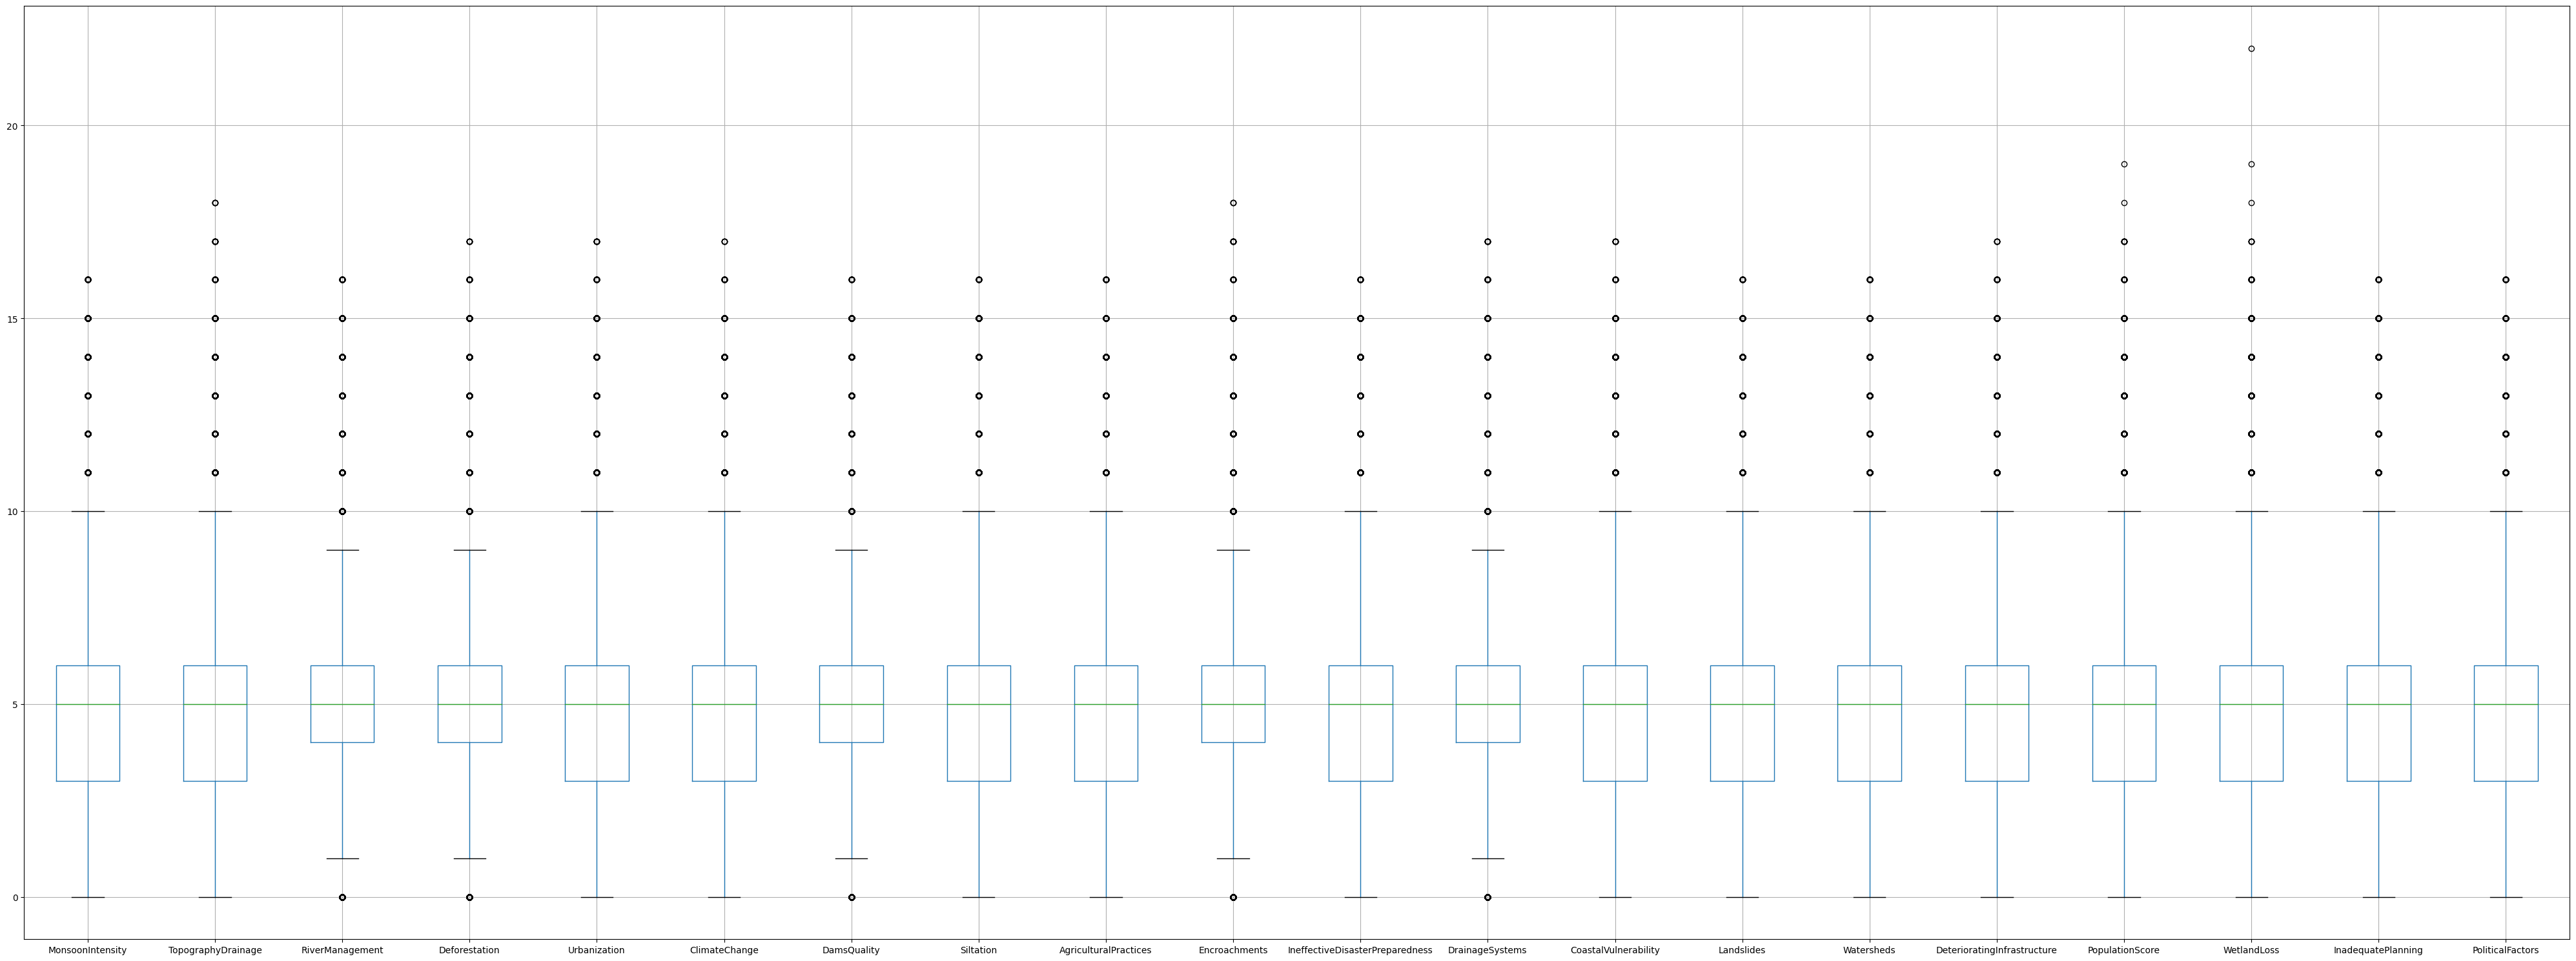

In [28]:
# plot boxplot
train[train.columns[:20]].boxplot(figsize=(40,15))
plt.tight_layout()
plt.show()

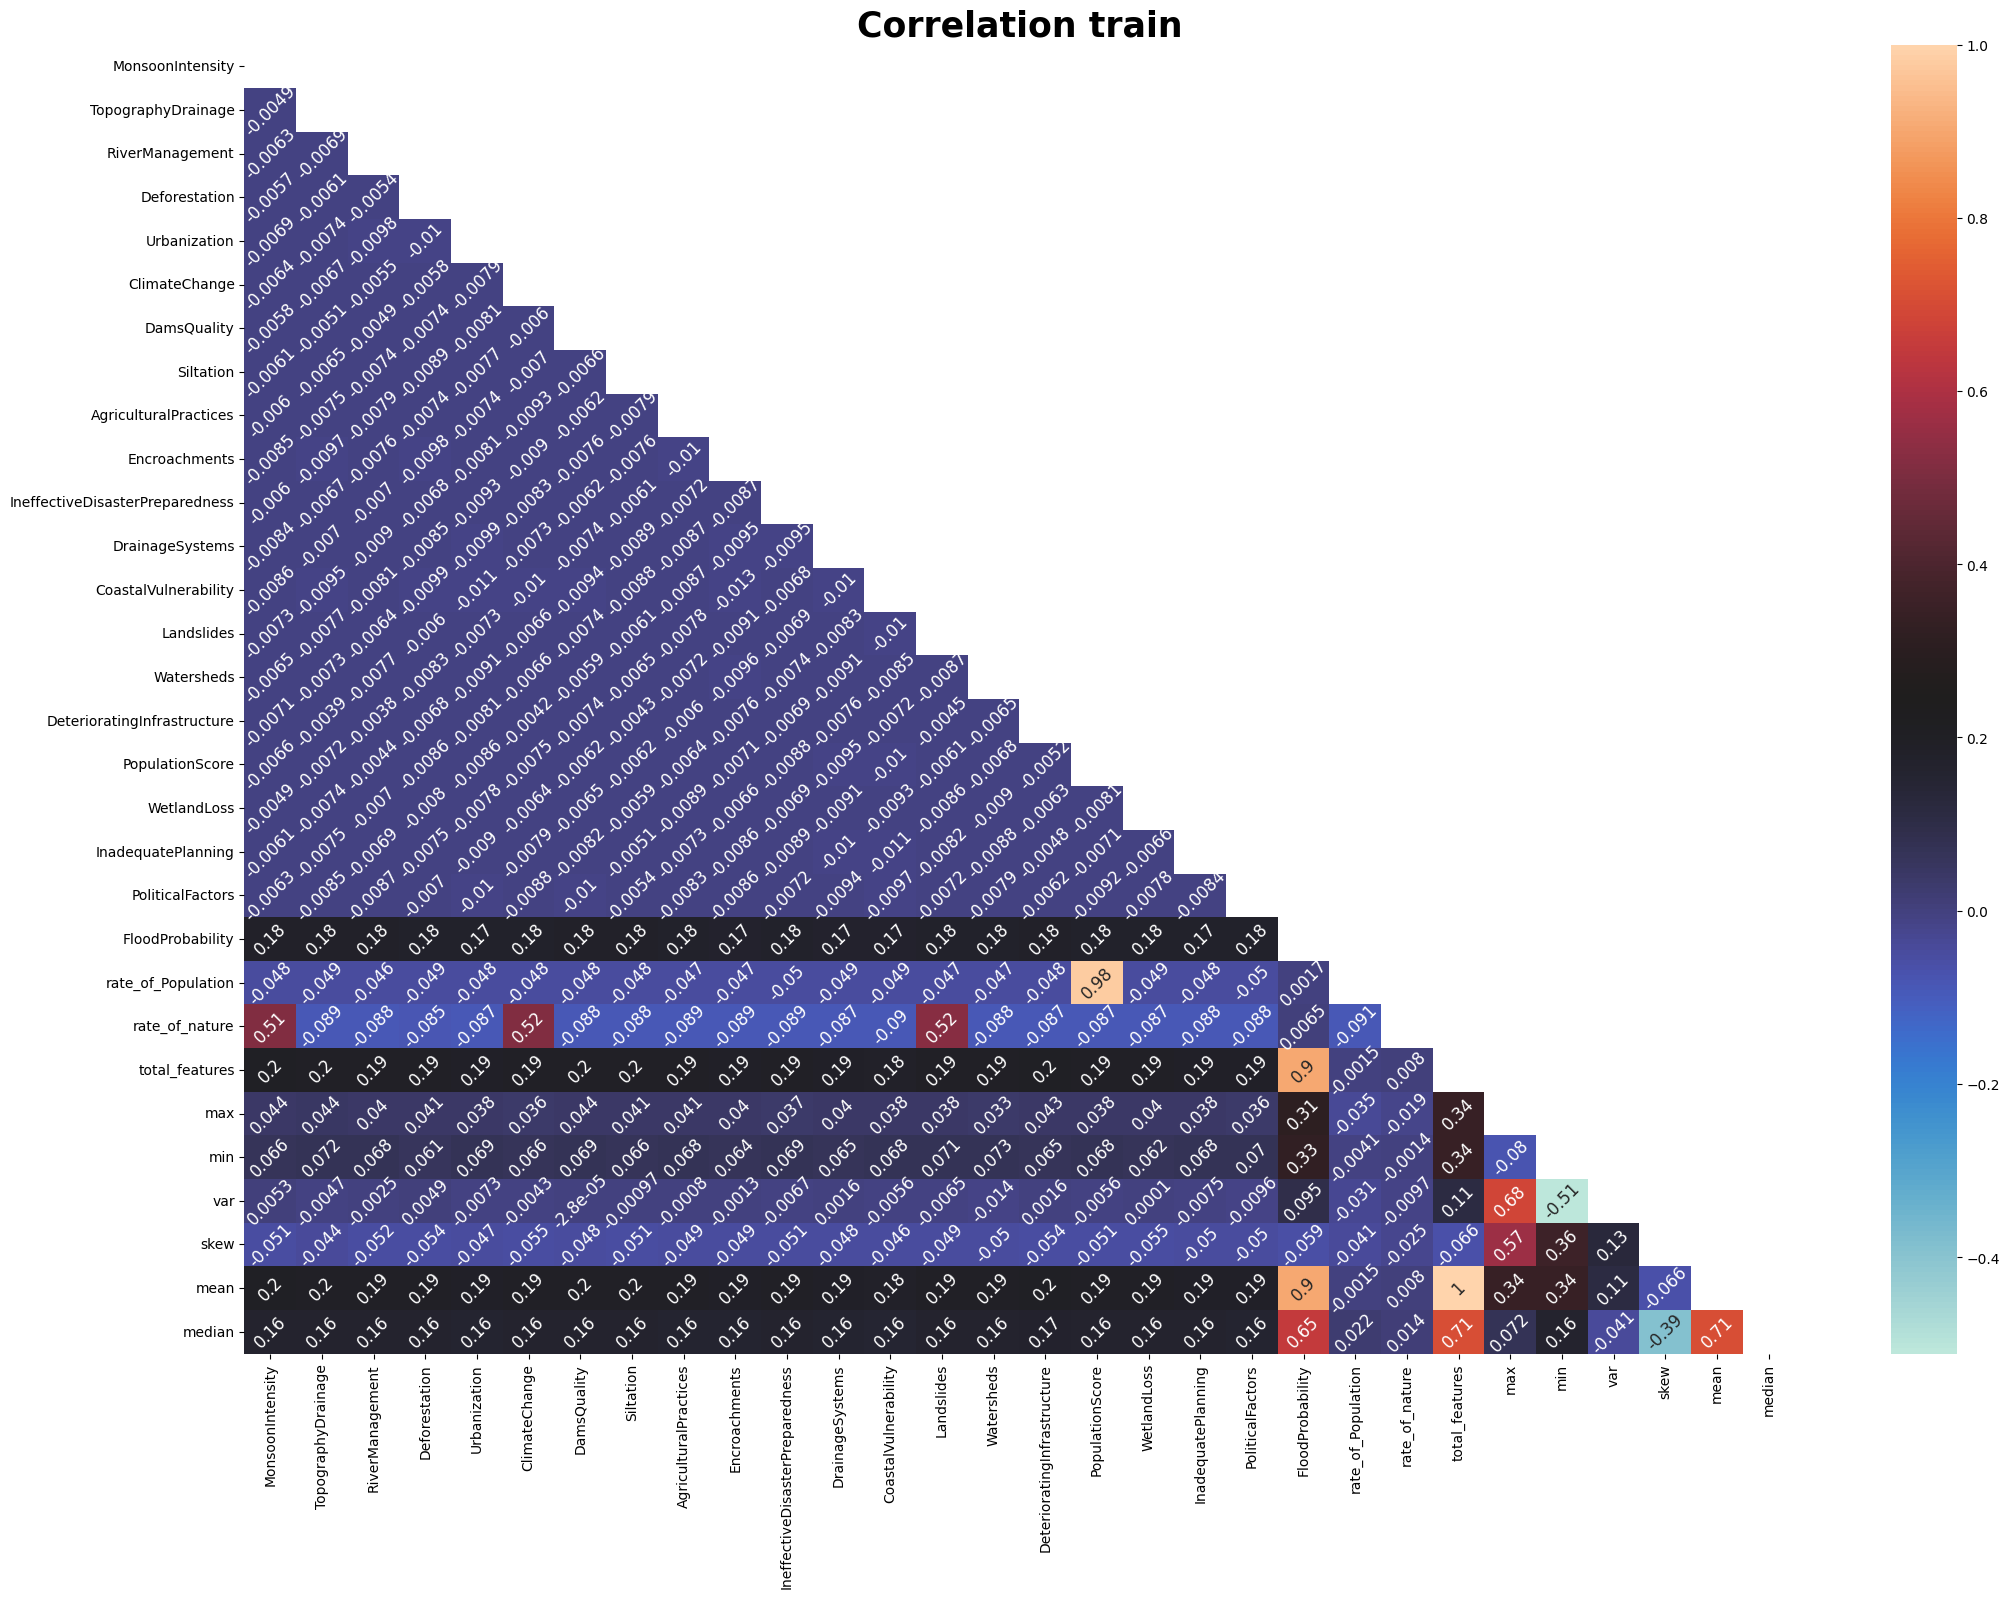

In [18]:
# correlation graph
corr = train._get_numeric_data().corr(method='spearman')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
fig, ax = plt.subplots(figsize=(25,17))
sns.heatmap(data=corr, 
        mask=mask , 
        annot=True,
        cmap='icefire',
        annot_kws={'size': 12, 'rotation': 45},
        ax=ax
        );
ax.set_title('Correlation train',fontsize=25, fontweight='bold');

In [10]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [11]:
%%time
train= reduce_mem_usage(train)
test= reduce_mem_usage(test)
print("Shape of train set: ",train.shape)
print("Shape of test set: ",test.shape)

Mem. usage decreased to 31.19 Mb (85.4% reduction)
Mem. usage decreased to 21.32 Mb (84.4% reduction)
Shape of train set:  (1167957, 24)
Shape of test set:  (745305, 24)
CPU times: total: 2.58 s
Wall time: 2.7 s


#### Model Training and Prediction

In [17]:
from optuna.samplers import TPESampler

def objective(trial):

    params = {
        'num_leaves': trial.suggest_int('num_leaves', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 300, 1200),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 500),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.25, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        'metric': 'mse'
    }
   
    
    scores = list()

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for _, (train_index, valid_index) in enumerate(cv.split(X, y)):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]

        model = LGBMRegressor(**params, objective='regression', random_state=0, device='gpu', verbosity = -1)

        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_valid)
        rmse = metrics.mean_squared_error(y_valid, y_pred)
        scores.append(rmse)
        
    return np.mean(scores)
    


if __name__ == "__main__":

    study = optuna.create_study(direction='minimize', study_name="optuna_LGBM")
    study.optimize(objective, n_trials=30)
    
    print("Best trial:")
    trial = study.best_trial
    
    print("Number of finished trials: {}".format(len(study.trials)))
    
    print(f"Best trial average RMSE: {study.best_value:.4f}")
    
    print("  Value: {}".format(trial.value))
    
    print("  Params: ")
    for key, value in study.best_params.items():
        print(f"{key}: {value}")

[I 2024-05-12 19:04:08,481] A new study created in memory with name: optuna_LGBM
[I 2024-05-12 19:04:48,966] Trial 0 finished with value: 0.00034821749927371444 and parameters: {'num_leaves': 484, 'learning_rate': 0.31840633762523385, 'n_estimators': 431, 'min_child_samples': 337, 'reg_alpha': 0.025404734668916913, 'reg_lambda': 5.215225817342422e-06, 'colsample_bytree': 0.44371800234974446, 'subsample': 0.6848538946522481, 'max_depth': 1}. Best is trial 0 with value: 0.00034821749927371444.
[I 2024-05-12 19:08:54,363] Trial 1 finished with value: 0.00034122510820947845 and parameters: {'num_leaves': 374, 'learning_rate': 0.05081222627366387, 'n_estimators': 966, 'min_child_samples': 139, 'reg_alpha': 6.570844604739186e-06, 'reg_lambda': 1.5698558521869091e-07, 'colsample_bytree': 0.7321515286545934, 'subsample': 0.8567952839643662, 'max_depth': 6}. Best is trial 1 with value: 0.00034122510820947845.
[I 2024-05-12 19:10:41,765] Trial 2 finished with value: 0.00034025421507262785 and pa

Best trial:
Number of finished trials: 30
Best trial average RMSE: 0.0003
  Value: 0.00033886527777073625
  Params: 
num_leaves: 257
learning_rate: 0.016156991090809633
n_estimators: 589
min_child_samples: 41
reg_alpha: 1.0870828881219888e-08
reg_lambda: 6.64325147438338e-08
colsample_bytree: 0.8247845152260886
subsample: 0.7272039636689276
max_depth: 15


In [21]:
X = train.drop('FloodProbability',axis=1)
y = train['FloodProbability']

Params={ 
'num_leaves': 257,
'learning_rate': 0.016156991090809633,
'n_estimators': 589,
'min_child_samples': 41,
'reg_alpha': 1.0870828881219888e-08,
'reg_lambda': 6.64325147438338e-08,
'colsample_bytree': 0.8247845152260886,
'subsample': 0.7272039636689276,
'max_depth': 15}



scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(test.drop('id',axis=1))

model = LGBMRegressor(**Params,random_state=11)
model.fit(X_scaled,y)
preds = model.predict(test_scaled)
train_pred = model.predict(X_scaled)
score = metrics.r2_score(train_pred,y)

print('r2 score: ',score)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 957
[LightGBM] [Info] Number of data points in the train set: 1167957, number of used features: 23
[LightGBM] [Info] Start training from score 0.504273
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
r2 score:  0.8552457968366376


In [23]:
# sub['FloodProbability'] = preds

In [24]:
# sub.to_csv('submis.csv',index=False)

#### LGBM regressor optuna

In [49]:
from optuna.samplers import TPESampler

def objective(trial):

    params = {
        'num_leaves': trial.suggest_int('num_leaves', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 300, 1200),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 500),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.25, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        'metric': 'mse'
    }
   
    
    scores = list()

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for _, (train_index, valid_index) in enumerate(cv.split(X, y)):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]

        model = LGBMRegressor(**params, objective='regression', random_state=0, device='gpu', verbosity = -1)

        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_valid)
        rmse = metrics.mean_squared_error(y_valid, y_pred)
        scores.append(rmse)
        
    return np.mean(scores)
    


if __name__ == "__main__":

    study = optuna.create_study(direction='minimize', study_name="optuna_LGBM")
    study.optimize(objective, n_trials=50)
    
    print("Best trial:")
    trial = study.best_trial
    
    print("Number of finished trials: {}".format(len(study.trials)))
    
    print(f"Best trial average RMSE: {study.best_value:.4f}")
    
    print("  Value: {}".format(trial.value))
    
    print("  Params: ")
    for key, value in study.best_params.items():
        print(f"{key}: {value}")

[I 2024-05-12 23:27:00,886] A new study created in memory with name: optuna_LGBM
[I 2024-05-12 23:40:43,763] Trial 0 finished with value: 0.0003382522956081641 and parameters: {'num_leaves': 247, 'learning_rate': 0.09530562324326675, 'n_estimators': 1081, 'min_child_samples': 217, 'reg_alpha': 0.018483824962371723, 'reg_lambda': 0.00012181856829667, 'colsample_bytree': 0.6887297466541304, 'subsample': 0.9040440810848268, 'max_depth': 7}. Best is trial 0 with value: 0.0003382522956081641.
[I 2024-05-12 23:45:30,936] Trial 1 finished with value: 0.0003393923043804944 and parameters: {'num_leaves': 382, 'learning_rate': 0.11628857410199907, 'n_estimators': 664, 'min_child_samples': 290, 'reg_alpha': 9.84082015410555, 'reg_lambda': 6.433617763573474e-08, 'colsample_bytree': 0.7631624185477186, 'subsample': 0.48086976128745784, 'max_depth': 3}. Best is trial 0 with value: 0.0003382522956081641.
[I 2024-05-12 23:56:34,403] Trial 2 finished with value: 0.0003365969467858205 and parameters: {'

Best trial:
Number of finished trials: 50
Best trial average RMSE: 0.0003
  Value: 0.0003355563713390031
  Params: 
num_leaves: 232
learning_rate: 0.014851677977501228
n_estimators: 515
min_child_samples: 391
reg_alpha: 5.931271581176665e-06
reg_lambda: 0.0017327100232200337
colsample_bytree: 0.9979477846154563
subsample: 0.9361286998745009
max_depth: 9


In [51]:
X = train.drop('FloodProbability',axis=1)
y = train['FloodProbability']

Params={ 
'num_leaves': 232,
'learning_rate': 0.014851677977501228,
'n_estimators': 515,
'min_child_samples': 391,
'reg_alpha': 5.931271581176665e-06,
'reg_lambda': 0.0017327100232200337,
'colsample_bytree': 0.9979477846154563,
'subsample': 0.9361286998745009,
'max_depth': 9}



scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(test)

model = LGBMRegressor(**Params,random_state=11)
model.fit(X_scaled,y)
pred = model.predict(test_scaled)
train_pred = model.predict(X_scaled)
score = metrics.r2_score(train_pred,y)

print('r2 score: ',score)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1489
[LightGBM] [Info] Number of data points in the train set: 1167957, number of used features: 27
[LightGBM] [Info] Start training from score 0.504273
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [52]:
# sub['FloodProbability'] = preds

In [53]:
# sub.to_csv('submissss.csv',index=False)

#### Xgboost optuna

In [18]:
from optuna.samplers import TPESampler
import time

%time


def objective(trial):
    
    params = {
        "eta": trial.suggest_float("eta", 0.001, 1),
        'min_child_weight' : trial.suggest_float("min_child_weight", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        'gamma': trial.suggest_float("gamma", 0.001, 1),
        'lambda' : trial.suggest_float("lambda", 0.001, 1),
        'alpha' : trial.suggest_float("alpha", 0.001, 1),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        'max_leaf_nodes': trial.suggest_float("max_leaf_nodes", 0.01, 1.0),
        'device': 'cuda' ,
        'objective':'reg:squaredlogerror'
        }


    cv = KFold(n_splits=5, shuffle=True, random_state=5)
    scores = []
    for _,(train_index, valid_index) in enumerate(cv.split(X, y)):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
        model = XGBRegressor(**params)

        model.fit(X_train, y_train, 
                  eval_set=[(X_valid, y_valid)],
                  early_stopping_rounds=40,
                  verbose=False)
        
        y_pred = model.predict(X_valid)
        scores.append(metrics.mean_squared_log_error(y_valid, y_pred))
    return np.mean(scores)


if __name__ == "__main__":

    study = optuna.create_study(direction='minimize', study_name="optuna_xgboost")
    study.optimize(objective, n_trials=50)
    
    print("Best trial:")
    trial = study.best_trial
    
    print("Number of finished trials: {}".format(len(study.trials)))
    
    print(f"Best trial average RMSE: {study.best_value:.4f}")
    
    print("  Value: {}".format(trial.value))
    
    print("  Params: ")
    for key, value in study.best_params.items():
        print(f"{key}: {value}")

[I 2024-05-13 23:09:58,684] A new study created in memory with name: optuna_xgboost


CPU times: total: 0 ns
Wall time: 0 ns


[I 2024-05-13 23:10:20,944] Trial 0 finished with value: 0.0003703916445374489 and parameters: {'eta': 0.8615571048144067, 'min_child_weight': 0.010097843665402478, 'max_depth': 14, 'gamma': 0.2285683528792733, 'lambda': 0.7773437594964879, 'alpha': 0.9118609044240363, 'subsample': 0.9321119887079135, 'colsample_bytree': 0.7102688056996957, 'learning_rate': 0.025488633820961115, 'max_leaf_nodes': 0.25079817406534544}. Best is trial 0 with value: 0.0003703916445374489.
[I 2024-05-13 23:10:39,698] Trial 1 finished with value: 0.00015523438923992217 and parameters: {'eta': 0.8003335640900163, 'min_child_weight': 0.00474745405536584, 'max_depth': 9, 'gamma': 0.12527254948081196, 'lambda': 0.7088566852451129, 'alpha': 0.37579042698293524, 'subsample': 0.9550978265980706, 'colsample_bytree': 0.8974200710148108, 'learning_rate': 0.09422408531153709, 'max_leaf_nodes': 0.2716301854757857}. Best is trial 1 with value: 0.00015523438923992217.
[I 2024-05-13 23:11:01,175] Trial 2 finished with valu

Best trial:
Number of finished trials: 50
Best trial average RMSE: 0.0002
  Value: 0.00015024114691186696
  Params: 
eta: 0.49615511237425014
min_child_weight: 0.004598019381028494
max_depth: 11
gamma: 0.0020493079858246166
lambda: 0.1307854056414332
alpha: 0.28414544840959177
subsample: 0.9733851914796902
colsample_bytree: 0.9678555082987941
learning_rate: 0.07164504226806746
max_leaf_nodes: 0.550791614044707


In [20]:
Xgb_Params = { 
    'eta': 0.49615511237425014,
    'min_child_weight': 0.004598019381028494,
    'max_depth': 11,
    'gamma': 0.0020493079858246166,
    'lambda': 0.1307854056414332,
    'alpha': 0.28414544840959177,
    'subsample': 0.9733851914796902,
    'colsample_bytree': 0.9678555082987941,
    'learning_rate': 0.07164504226806746,
    'max_leaf_nodes': 0.550791614044707}

X = train.drop('FloodProbability',axis=1)
y = train['FloodProbability']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(test)

model = XGBRegressor(**Xgb_Params,random_state=11)
model.fit(X_scaled,y)
pred = model.predict(test_scaled)
train_pred = model.predict(X_scaled)
score = metrics.r2_score(train_pred,y)

print('r2 score: ',score)


r2 score:  0.8535660441827565


In [21]:
# sub['FloodProbability'] = pred

#### CatboostRegressor optuna

In [12]:
model = CatBoostRegressor()

model.fit(X, y)

y_pred = model.predict(test)
train_pred = model.predict(X)
r2 = metrics.r2_score(y,train_pred)
r2

Learning rate set to 0.124978
0:	learn: 0.0457722	total: 438ms	remaining: 7m 17s
1:	learn: 0.0412501	total: 625ms	remaining: 5m 11s
2:	learn: 0.0373947	total: 860ms	remaining: 4m 45s
3:	learn: 0.0341104	total: 1.06s	remaining: 4m 24s
4:	learn: 0.0313293	total: 1.28s	remaining: 4m 15s
5:	learn: 0.0289832	total: 1.48s	remaining: 4m 4s
6:	learn: 0.0270463	total: 1.7s	remaining: 4m
7:	learn: 0.0254384	total: 1.89s	remaining: 3m 53s
8:	learn: 0.0240968	total: 2.11s	remaining: 3m 52s
9:	learn: 0.0230167	total: 2.3s	remaining: 3m 47s
10:	learn: 0.0221431	total: 2.5s	remaining: 3m 45s
11:	learn: 0.0214368	total: 2.68s	remaining: 3m 40s
12:	learn: 0.0208609	total: 2.88s	remaining: 3m 38s
13:	learn: 0.0204039	total: 3.08s	remaining: 3m 36s
14:	learn: 0.0200383	total: 3.3s	remaining: 3m 36s
15:	learn: 0.0197425	total: 3.53s	remaining: 3m 37s
16:	learn: 0.0195153	total: 3.78s	remaining: 3m 38s
17:	learn: 0.0193302	total: 4s	remaining: 3m 38s
18:	learn: 0.0191897	total: 4.25s	remaining: 3m 39s
19:	

0.872816680838324

In [13]:
# sub['FloodProbability'] = y_pred
# sub.to_csv('catboostsub.csv',index=False)

### VOTING REGRESSOR

In [20]:
from sklearn.ensemble import VotingRegressor

In [27]:
lgbT = LGBMRegressor(**Params)
xgbT = XGBRegressor(**Xgb_Params)

X = train.drop('FloodProbability',axis=1)
y = train['FloodProbability']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(test)


voting_reg = VotingRegressor(estimators=[('xgb', xgbT), ('cbr', lgbT)],
                             n_jobs=-1, verbose=2)

voting_reg.fit(X_scaled,y)


pred = voting_reg.predict(test_scaled)
X_pred = voting_reg.predict(X_scaled)
# Calculate Mean Absolute Error (MSE)
mse = metrics.mean_squared_error(y, X_pred)
 

 
# Print the evaluation metrics
print(f'Root mean squared log error (mse): {mse:.4f}')

Root mean squared log error (mse): 0.00


In [28]:
# sub['FloodProbability'] = pred
# sub.to_csv('votingsub.csv',index=False)

#### Final submission and VotingRegressor

In [20]:
lgbT = LGBMRegressor(**lbg_Params)
xgbT = XGBRegressor(**Xgb_Params)
ctbT = CatBoostRegressor()

X = train.drop('FloodProbability',axis=1)
y = train['FloodProbability']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(test)


voting_reg = VotingRegressor(estimators=[('xgb', xgbT), ('lgb', lgbT),('cbr',ctbT)],
                             n_jobs=-1, verbose=2)

voting_reg.fit(X_scaled,y)


pred = voting_reg.predict(test_scaled)
X_pred = voting_reg.predict(X_scaled)
# Calculate Mean Absolute Error (MSE)
r2 = metrics.r2_score(y, X_pred)
 

 
# Print the evaluation metrics
print(f'Root mean squared log error (r2): {r2:.4f}')

Root mean squared log error (r2): 0.8729


In [21]:
# sub['FloodProbability'] = pred
# sub.to_csv('submission_voting.csv',index=False)